In [1]:
# 使用伪码表生成wave从而得到对比训练集，防止恒正运算
# server给subject提供一个伪码表，subject利用伪码表生成对应的对照集
# 伪码与最终的hash key或者BCH code无关
# 判别器需要保留一定的分辨能力
# data index range [2, 66]
import torch
import torch.nn as nn
from torch.nn import *
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os

from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

from preprocess_v2 import Process

In [2]:
seed = 27
def get_random_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
get_random_seed(seed)

In [3]:
series = []
items = 1
step = 3
subject_num = 0

for num in range(2, 66):
    try:
        sig, sec_sig = Process(num).prepro(1024, step)
        series += sec_sig
        subject_num += 1
    except:
        print(f'subject {num} abandoned')

subject 13 abandoned
subject 16 abandoned
subject 17 abandoned
subject 18 abandoned
subject 20 abandoned
subject 26 abandoned


/home/dhz/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/dhz/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/dhz/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


subject 42 abandoned
subject 47 abandoned
subject 48 abandoned
subject 50 abandoned


In [4]:
class MyDataset(Dataset):
    def __init__(self, series, items, subject_num):
        self.series = series
        self.codes = []
        self.subject_num = subject_num
        self.labels = np.zeros((len(self.series), self.subject_num), dtype='double')
        for i in range(self.subject_num):
            for j in range(step - 1):
                self.labels[i * (step - 1) + j][i] = 1.0

    # need to overload
    def __len__(self):
        return len(self.series)

    # need to overload
    def __getitem__(self, idx):
        return self.series[idx], torch.tensor(self.labels[idx])

In [5]:
dataset = MyDataset(series, items=items, subject_num=subject_num)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16, shuffle=True)

In [6]:
class ConvolutionBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ConvolutionBlock, self).__init__()
        self.block = nn.Sequential(nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.block(x)
        return x

In [7]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers, num_heads, dropout, num_conv_blocks):
        super(TransformerClassifier, self).__init__()
        self.conv1 = ConvolutionBlock(input_size, hidden_size)
        self.conv_blocks = nn.ModuleList([
            ConvolutionBlock(hidden_size, hidden_size) for _ in range(num_conv_blocks)
        ])
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, hidden_size, seq_len)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Average the sequence dimension
        x = torch.sigmoid(self.fc(x))
        return x

In [8]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
# Example usage
input_size = 1
hidden_size = 128
num_classes = 54
num_layers = 6
num_heads = 4
dropout = 0.2
batch_size = 16
num_epochs = 10
num_conv_blocks = 2

In [10]:
cls = TransformerClassifier(input_size, hidden_size, num_classes, num_layers, num_heads, dropout, num_conv_blocks).to(device)
cls = cls.double()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cls.parameters(), lr=1e-5)
# learning 2e-5, momentum 0.1, rate=50% max = 66.7%
# learning 2e-5, momentum 2e-3, max = 94.4%
# lr 2e-2, momentum 2e-3, max = 67.3%
# with sigmoid
# SGD lr 2e-5 momentum 2e-3 max = 33.3%

In [12]:
C_loss = []
C_acc = []

In [13]:
for epoch in range(5000):
    epoch_iterator = tqdm(dataloader, desc="Training Epoch %d" % (epoch + 1), ncols = 100)
    #初始化损失值
    c_epoch_loss = 0
    acc_num = 0
    num = 0
    count = len(dataloader) #返回批次数
    #对数据集进行迭代
    for step, (subject, label) in enumerate(epoch_iterator):
        subject = torch.reshape(subject, (subject.size(0), 1, subject.size(1)))
        subject = subject.to(device) #把数据放到设备上
        label = label.to(device)
        size = subject.size(0)
        num += size
        
        class_train = cls(subject)
        c_loss = criterion(class_train, label)
        c_loss.backward()
        optimizer.step()
        
        for i in range(subject.size(0)):
            idx1 = torch.argmax(class_train[i])
            idx2 = torch.argmax(label[i])
            if idx1 == idx2:
                acc_num += 1
        
        #累计每一个批次的loss
        with torch.no_grad():
            c_epoch_loss += c_loss
        epoch_iterator.set_postfix({"c_loss": '{0:1.5f}'.format(c_epoch_loss), "accuracy": '{0:1.3f}'.format(acc_num / num)})
        epoch_iterator.update(1)
            
    #求平均损失
    with torch.no_grad():
        c_epoch_loss /= count
        acc = acc_num / num
        C_loss.append(c_epoch_loss)
        C_acc.append(acc)
    if acc >=0.9:
        break

Training Epoch 81: 100%|█████████████| 7/7 [00:01<00:00,  6.64it/s, c_loss=26.86056, accuracy=0.213]


Training Epoch 162: 100%|████████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=26.03235, accuracy=0.296]


Training Epoch 243: 100%|████████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=25.51915, accuracy=0.269]


Training Epoch 324: 100%|████████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=25.15289, accuracy=0.324]


Training Epoch 405: 100%|████████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=24.78875, accuracy=0.352]


Training Epoch 486: 100%|████████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=24.61128, accuracy=0.352]


Training Epoch 567: 100%|████████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=24.29696, accuracy=0.361]


Training Epoch 648: 100%|████████████| 7/7 [00:01<00:00,  6.63it/s, c_loss=24.06922, accuracy=0.407]


Training Epoch 729: 100%|████████████| 7/7 [00:01<00:00,  6.60it/s, c_loss=23.98064, accuracy=0.407]


Training Epoch 810: 100%|████████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=23.75445, accuracy=0.426]


Training Epoch 891: 100%|████████████| 7/7 [00:01<00:00,  6.60it/s, c_loss=23.54813, accuracy=0.481]


Training Epoch 972: 100%|████████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=23.62928, accuracy=0.398]


Training Epoch 1053: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=23.23442, accuracy=0.537]


Training Epoch 1134: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=23.13699, accuracy=0.528]


Training Epoch 1215: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=23.03714, accuracy=0.528]


Training Epoch 1296: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=22.93211, accuracy=0.574]


Training Epoch 1377: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=22.81950, accuracy=0.528]


Training Epoch 1458: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=22.73591, accuracy=0.565]


Training Epoch 1539: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=22.67082, accuracy=0.630]


Training Epoch 1620: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=22.58421, accuracy=0.639]


Training Epoch 1701: 100%|███████████| 7/7 [00:01<00:00,  6.63it/s, c_loss=22.58764, accuracy=0.657]


Training Epoch 1782: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=22.42857, accuracy=0.713]


Training Epoch 1863: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=22.36237, accuracy=0.694]


Training Epoch 1944: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=22.29541, accuracy=0.731]


Training Epoch 2025: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=22.23387, accuracy=0.750]


Training Epoch 2106: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=22.16387, accuracy=0.741]


Training Epoch 2187: 100%|███████████| 7/7 [00:01<00:00,  6.60it/s, c_loss=22.12696, accuracy=0.704]


Training Epoch 2268: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=22.12130, accuracy=0.787]


Training Epoch 2349: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=22.03742, accuracy=0.769]


Training Epoch 2430: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=22.02475, accuracy=0.750]


Training Epoch 2511: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.99191, accuracy=0.778]


Training Epoch 2592: 100%|███████████| 7/7 [00:01<00:00,  6.60it/s, c_loss=21.93656, accuracy=0.731]


Training Epoch 2673: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.97187, accuracy=0.722]


Training Epoch 2754: 100%|███████████| 7/7 [00:01<00:00,  6.63it/s, c_loss=21.84870, accuracy=0.787]


Training Epoch 2835: 100%|███████████| 7/7 [00:01<00:00,  6.60it/s, c_loss=21.81418, accuracy=0.796]


Training Epoch 2916: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.81843, accuracy=0.796]


Training Epoch 2997: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.78341, accuracy=0.806]


Training Epoch 3078: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.75815, accuracy=0.769]


Training Epoch 3159: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.72972, accuracy=0.806]


Training Epoch 3240: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.68821, accuracy=0.796]


Training Epoch 3321: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.66168, accuracy=0.815]


Training Epoch 3402: 100%|███████████| 7/7 [00:01<00:00,  6.60it/s, c_loss=21.67922, accuracy=0.778]


Training Epoch 3483: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.68687, accuracy=0.759]


Training Epoch 3564: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.66241, accuracy=0.778]


Training Epoch 3645: 100%|███████████| 7/7 [00:01<00:00,  6.60it/s, c_loss=21.61965, accuracy=0.815]


Training Epoch 3726: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.58358, accuracy=0.824]


Training Epoch 3807: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.58153, accuracy=0.806]


Training Epoch 3888: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.55590, accuracy=0.806]


Training Epoch 3969: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.55000, accuracy=0.824]


Training Epoch 4050: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.53224, accuracy=0.806]


Training Epoch 4131: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.50587, accuracy=0.815]


Training Epoch 4212: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.51178, accuracy=0.806]


Training Epoch 4293: 100%|███████████| 7/7 [00:01<00:00,  6.60it/s, c_loss=21.52692, accuracy=0.833]


Training Epoch 4374: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.49533, accuracy=0.843]


Training Epoch 4455: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.51298, accuracy=0.815]


Training Epoch 4536: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.49841, accuracy=0.843]


Training Epoch 4617: 100%|███████████| 7/7 [00:01<00:00,  6.64it/s, c_loss=21.48152, accuracy=0.824]


Training Epoch 4698: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.46023, accuracy=0.833]


Training Epoch 4779: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.45917, accuracy=0.852]


Training Epoch 4860: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.46940, accuracy=0.796]


Training Epoch 4941: 100%|███████████| 7/7 [00:01<00:00,  6.62it/s, c_loss=21.47430, accuracy=0.806]


Training Epoch 5000: 100%|███████████| 7/7 [00:01<00:00,  6.61it/s, c_loss=21.45921, accuracy=0.824]


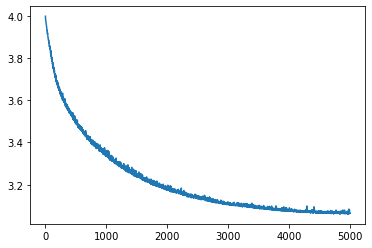

In [14]:
c_curve = [i.cpu() for i in C_loss]
plt.plot(c_curve)

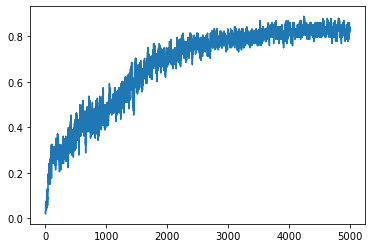

In [15]:
a_curve = [i for i in C_acc]
plt.plot(a_curve)

In [16]:
np.save('c_curve_v2.npy', c_curve)
np.save('a_curve_v2.npy', a_curve)

In [17]:
torch.save(cls, "classification_v2")